# Bode Diagrams

### First-Order System

In [2]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sys = signal.TransferFunction([0.2], [0.2, 1.2,1])
sys1 = signal.TransferFunction([1],[1,1])
sys2 = signal.TransferFunction([1],[0.2,1])
w, mag, phase = signal.bode(sys)
w1, mag1, phase1 = signal.bode(sys1)
w2,mag2, phase2 = signal.bode(sys2)

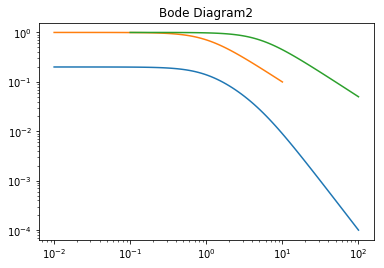

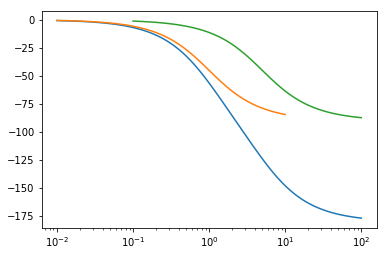

In [4]:
a=2
plt.title('Bode Diagram'+str(a))
#plt.title('AR vs w')
plt.loglog(w, 10**(mag/20))    # Bode magnitude plot
plt.loglog(w1, 10**(mag1/20))
plt.loglog(w2, 10**(mag2/20))

plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.semilogx(w1,phase1)
plt.semilogx(w2,phase2)

### Second-Order System

In [11]:
tau = 1.0
zeta = 0.1

In [12]:
tf = signal.TransferFunction([1.0],[tau**2,2*zeta*tau,1.0])

In [13]:
w, mag, phase = signal.bode(tf)

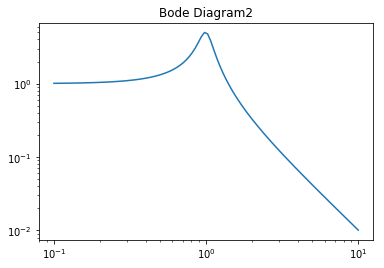

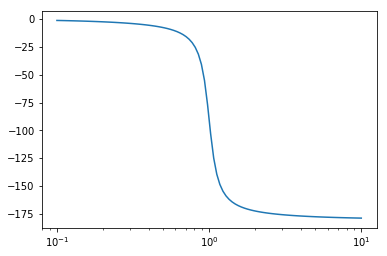

In [14]:
plt.title('Bode Diagram'+str(a))
#plt.title('AR vs w')
plt.loglog(w, 10**(mag/20))    # Bode magnitude plot
#plt.loglog(w1, 10**(mag1/20))
#plt.loglog(w2, 10**(mag2/20))

plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
#plt.semilogx(w1,phase1)
#plt.semilogx(w2,phase2)

### Proportional-Integral Controller

$G(s) = K_{c}(1+\frac{1}{\tau_{I}s})$

In [18]:
Kc = 1.0
Ti = 0.5
num = [Kc*Ti, Kc]
den = [Ti,0]
tf = signal.TransferFunction(num,den)

In [19]:
w, mag, phase = signal.bode(tf)

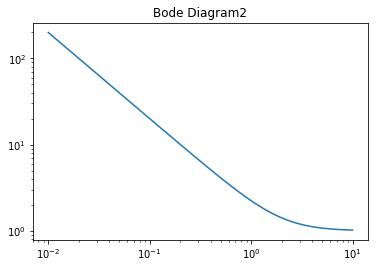

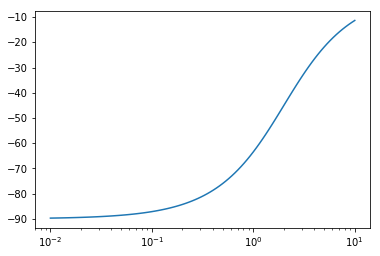

In [20]:
plt.title('Bode Diagram'+str(a))
#plt.title('AR vs w')
plt.loglog(w, 10**(mag/20))    # Bode magnitude plot
#plt.loglog(w1, 10**(mag1/20))
#plt.loglog(w2, 10**(mag2/20))

plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
#plt.semilogx(w1,phase1)
#plt.semilogx(w2,phase2)

### Proprtional-Derivative Controller

$G(s) = K_{c}(1+\tau_{D}s)$

In [21]:
Kc = 1.0
Td = 0.5
num = [Kc*Td, Kc]
den = [1]
tf = signal.TransferFunction(num,den)

In [22]:
w, mag, phase = signal.bode(tf)

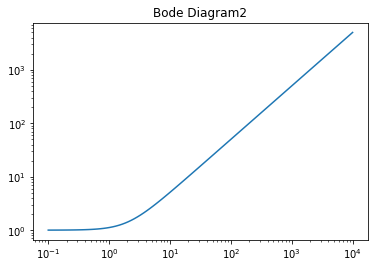

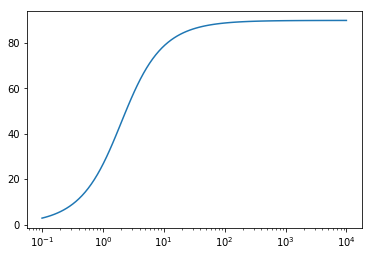

In [23]:
plt.title('Bode Diagram'+str(a))
#plt.title('AR vs w')
plt.loglog(w, 10**(mag/20))    # Bode magnitude plot
#plt.loglog(w1, 10**(mag1/20))
#plt.loglog(w2, 10**(mag2/20))

plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
#plt.semilogx(w1,phase1)
#plt.semilogx(w2,phase2)

In [18]:
Kc = 10.0
Ti = 0.5
num = [Kc*Ti*exp(, Kc]
den = [Ti,0]
tf = signal.TransferFunction(num,den)

In [19]:
w, mag, phase = signal.bode(tf)

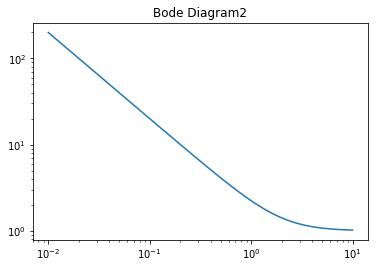

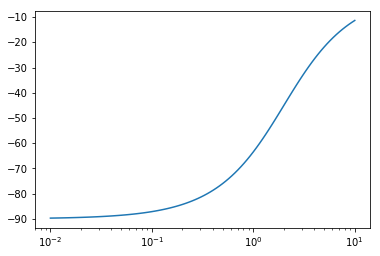

In [20]:
plt.title('Bode Diagram'+str(a))
#plt.title('AR vs w')
plt.loglog(w, 10**(mag/20))    # Bode magnitude plot
#plt.loglog(w1, 10**(mag1/20))
#plt.loglog(w2, 10**(mag2/20))

plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
#plt.semilogx(w1,phase1)
#plt.semilogx(w2,phase2)

In [25]:

#I checked out the ltisys module at github and attempted to create a LTI class with time delay. I think, it should be straightforward to introduce a input time delay in the state equation , if we replace BU(t) by BU(t-Td) where Td is the time delay. Following approach works for single input single output system. May not be free of bugs , but it solved my purpose.

#Inherit the parent LTI class  to create LTI class with time delay 


class ltidelay(lti):
    def __init__(self,inputdelay,*args,**kwargs):
        super(ltidelay,self).__init__(*args,**kwargs)    
        self.d =inputdelay

#define a method to simulate LTI with time delay . just copied lsim2 and made 2 changes. 1. passed the delay from the `ltidelay` object and 2. modified the state equation.


def lsim3(system , U=None, T=None,X0=None, **kwargs):
    if isinstance(system,lti):
        sys = system
    else:
        sys = lti(*system)
    delay = sys.d
    if X0 is  None:
        X0 = zeros(sys.B.shape[0],sys.A.dtype)        
    if T is None:
        T = linspace(0,10,101)
    T = atleast_1d(T)
    if len(T.shape) != 1:
        raise ValueError("T must be a rank1 array")
    if U is not None:
        U = atleast_1d(U)
        if len(U.shape)==1:
            U=U.reshape(-1,1)
        sU = U.shape
        if sU[0] != len(T):
            raise ValueError("U must have the same number of rows as elements in T")
        if sU[1] != sys.inputs:
            raise ValueError("The number of inputs in U is not compatible")
        ufunc = interpolate.interp1d(T, U, kind ='linear',axis =0,bounds_error =False)
        def fprime(x,t,sys,ufunc):
            return  dot(sys.A,x)+squeeze(dot(sys.B,nan_to_num(ufunc([t-delay]))))
        xout = odeint(fprime,X0,T,args=(sys,ufunc),**kwargs)
        yout = dot(sys.C,transpose(xout))
    else:
        def fprime(x,t,sys):
            return dot(sys.A,x)
        xout = odeint(fprime,X0,T,args=(sys,),**kwargs)
        yout = dot(sys.C, transpose(xout))
    return T , squeeze(transpose(yout)),xout   

#create an LTI system with delay 10

tf = ltidelay(10,2,[4,1])

#create a step signal and time vector to simulate the LTI and check


u = linspace(0,0,100)

u[50:100] = 1

t = linspace(1,100,100)

#check the simulation
y = lsim3(tf,u,t,X0 =0)

plot(y[1])

NameError: name 'lti' is not defined

In [28]:
a,b = sys.impulse()

In [29]:
a

array([0.        , 0.07070707, 0.14141414, 0.21212121, 0.28282828,
       0.35353535, 0.42424242, 0.49494949, 0.56565657, 0.63636364,
       0.70707071, 0.77777778, 0.84848485, 0.91919192, 0.98989899,
       1.06060606, 1.13131313, 1.2020202 , 1.27272727, 1.34343434,
       1.41414141, 1.48484848, 1.55555556, 1.62626263, 1.6969697 ,
       1.76767677, 1.83838384, 1.90909091, 1.97979798, 2.05050505,
       2.12121212, 2.19191919, 2.26262626, 2.33333333, 2.4040404 ,
       2.47474747, 2.54545455, 2.61616162, 2.68686869, 2.75757576,
       2.82828283, 2.8989899 , 2.96969697, 3.04040404, 3.11111111,
       3.18181818, 3.25252525, 3.32323232, 3.39393939, 3.46464646,
       3.53535354, 3.60606061, 3.67676768, 3.74747475, 3.81818182,
       3.88888889, 3.95959596, 4.03030303, 4.1010101 , 4.17171717,
       4.24242424, 4.31313131, 4.38383838, 4.45454545, 4.52525253,
       4.5959596 , 4.66666667, 4.73737374, 4.80808081, 4.87878788,
       4.94949495, 5.02020202, 5.09090909, 5.16161616, 5.23232

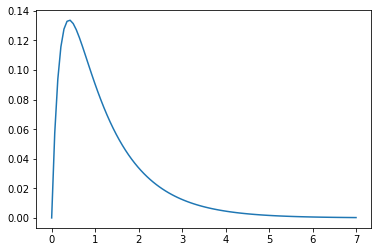

In [30]:
plt.plot(a,b)

In [31]:
c,d = sys.step()

(0, 0.2)

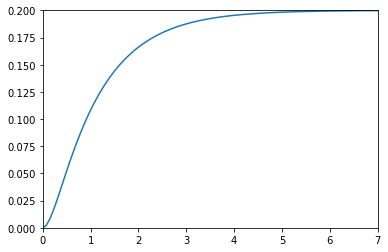

In [38]:
plt.plot(c,d)
plt.xlim(0,7)
plt.ylim(0,0.2)

In [33]:
e,f = sys.impulse()

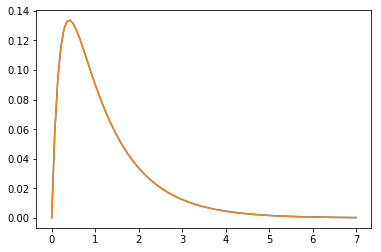

In [35]:

plt.plot(e,f)

In [42]:
sys.poles

array([-5., -1.])